In [1]:
import numpy as np
import dataclasses

from qiskit_experiments.framework import BaseExperiment, BaseAnalysis, Options, AnalysisResultData, FitVal
from qiskit_experiments.curve_analysis import plot_curve_fit, plot_errorbar, curve_fit
from qiskit_experiments.curve_analysis.curve_fit import process_curve_data
from qiskit_experiments.curve_analysis.data_processing  import level2_probability

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Gate
from qiskit.test.mock import FakeValencia

from calibrations import linearized_cr_core_schedule
    
class LinearizedRzxRabiAnalysis(BaseAnalysis):
    @classmethod
    def _default_options(cls):
        return Options(
            parameter_guess={'alpha': np.pi * 0.5 / 500., 'phi0': 0., 'amp': 0.5, 'offset': 0.5}
        )
    
    def _run_analysis(self, experiment_data, parameter_guess=None, plot=True, ax=None):
        data = experiment_data.data()
        metadata = data[0]['metadata']
        
        xdata, ydata, ysigma = process_curve_data(data, lambda datum: level2_probability(datum, '00'))
        
        if parameter_guess is None:
            p0 = (np.pi * 0.5 / 500., 0., 0.5, 0.5)
        else:
            p0 = (parameter_guess['alpha'], parameter_guess['phi0'], parameter_guess['amp'], parameter_guess['offset'])
            
        def fun(x, alpha, phi0, amp, offset):
            return offset + amp * np.cos(alpha * x + phi0)
            
        fit_result = curve_fit(fun, xdata, ydata, p0, sigma=ysigma)
        
        if np.abs(fit_result.popt[1]) < np.pi / 4. and np.abs(fit_result.popt[2] - 0.5) < 0.1 and np.abs(fit_result.popt[3] - 0.5) < 0.1:
            quality = 'good'
        else:
            quality = 'bad'
        
        results = [
            AnalysisResultData('alpha', FitVal(fit_result.popt[0], fit_result.popt_err[0])),
            AnalysisResultData('phi0', FitVal(fit_result.popt[1], fit_result.popt_err[1])),
            AnalysisResultData('summary', None, chisq=fit_result.reduced_chisq, quality=quality, extra=fit_result)
        ]
                                         
        if plot:
            ax = plot_curve_fit(fun, fit_result, ax=ax, fit_uncertainty=True)
            ax = plot_errorbar(xdata, ydata, ysigma, ax=ax)
            ax.tick_params(labelsize=14)
            ax.set_title('Control={} Target={}'.format(metadata['control_qubit'], metadata['target_qubit']))
            ax.set_xlabel('GaussianSquare width', fontsize=16)
            ax.set_ylabel('P(00)', fontsize=16)
            ax.grid(True)
        
        return results, [ax.get_figure()]
    
class LinearizedRzxRabi(BaseExperiment):
    __analysis_class__ = LinearizedRzxRabiAnalysis
    
    def __init__(self, control_qubit, target_qubit, max_width=1000, step_size=32):
        super().__init__([control_qubit, target_qubit])
        
        self.control_qubit = control_qubit
        self.target_qubit = target_qubit
        self.max_width = max_width
        self.step_size = 32

    def circuits(self, backend=None):
        circuits = []

        register = QuantumRegister(2)
    
        if backend is None:
            backend = FakeValencia()
            print('Using FakeValencia for backend')
            
        backend_config = backend.configuration()
        calibrations = backend.defaults().instruction_schedule_map
        cx_schedule = calibrations.get('cx', [self.control_qubit, self.target_qubit])  

        cr_core_gate = Gate('cr_core_gate', 2, [])
        
        for width in range(0, self.max_width, self.step_size):
            cr_core_sched = linearized_cr_core_schedule(width, cx_schedule, backend, phi_label=width)
            
            circuit = QuantumCircuit(register)
            circuit.x(0)
            circuit.append(cr_core_gate, (0, 1))
            circuit.measure_all()

            circuit.add_calibration('cr_core_gate', (self.control_qubit, self.target_qubit), cr_core_sched)
            circuit.metadata = {
                'experiment_type': self._type,
                'control_qubit': self.control_qubit,
                'target_qubit': self.target_qubit,
                'xval': width
            }

            circuits.append(circuit)
        
        return circuits

In [2]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research', group='tokyo-1', project='main')
backend = provider.get_backend('ibm_lagos')
control_qubit = 5
target_qubit = 3

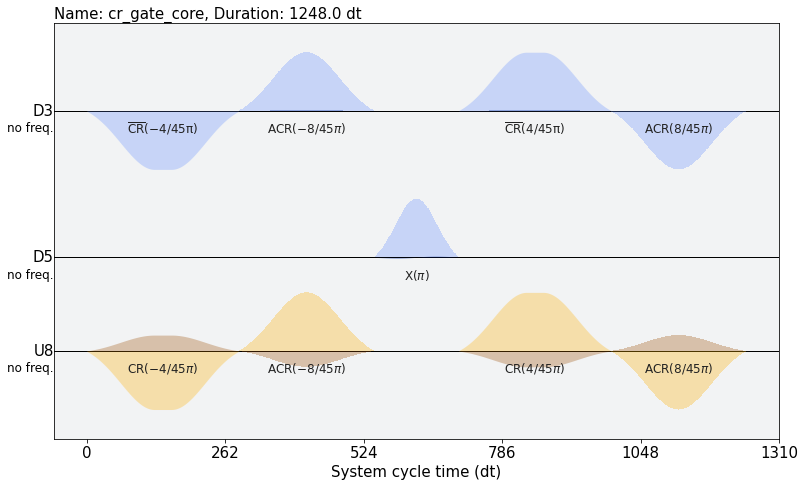

In [3]:
exp = LinearizedRzxRabi(control_qubit, target_qubit, max_width=512, step_size=16)
circuits = exp.circuits(backend)
circuits[1].calibrations['cr_core_gate'][((5, 3), tuple())].draw()

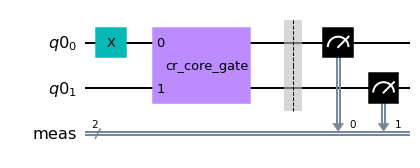

In [4]:
circuits[1].draw('mpl')

In [5]:
exp_data = exp.run(backend)
exp_data.block_for_results()

ExperimentData(LinearizedRzxRabi, 597f7f96-8070-44d3-af3c-c182d195a15a, backend=ibm_lagos, job_ids=['615c087b8fd55f66fcfac2e2'])

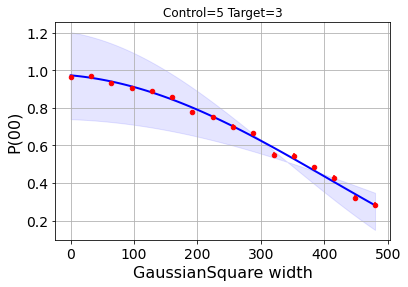

In [6]:
exp_data.figure(0)

In [10]:
exp_data.analysis_results('summary').extra

FitData(popt=array([0.00346354, 0.15500183, 0.56106524, 0.4182771 ]), popt_keys=None, popt_err=array([0.00061234, 0.05540026, 0.12214333, 0.11551786]), pcov=array([[ 3.74959861e-07, -2.67111736e-05, -7.41264699e-05,
         6.95504228e-05],
       [-2.67111736e-05,  3.06918917e-03,  4.77931475e-03,
        -4.26227794e-03],
       [-7.41264699e-05,  4.77931475e-03,  1.49189928e-02,
        -1.40832368e-02],
       [ 6.95504228e-05, -4.26227794e-03, -1.40832368e-02,
         1.33443769e-02]]), reduced_chisq=2.295683972876663, dof=12, x_range=(0.0, 480.0), y_range=(0.283203125, 0.970703125))

In [9]:
exp_data.save()